# Analysis of VoC data

Look at data provided to SPI-M on the B.1.351 VoC. 

Data file not included in the repo, so change path if running independently. 

This version:
* Data is that provided on 3 May
* Be clearer about travel versus non
* Be clearer about exponential versus constant
* Clearer labels of calendar dates


In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as st
import scipy.special as sp
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import scipy.optimize as op

In [2]:
df = pd.read_excel(
    '/Volumes/COVID19_Epi_modelling/DstlDailyData/2021-05-03/VOC202012_02_linelist_20210504.xlsx',
    sheet_name=1,
)
df.dropna(subset=['earliest_specimen_date'],inplace=True)

In [5]:
df

,finalid,earliest_specimen_date,PHEC_name,specimen_date_sk,seq_result,exposure_type,survey_or_intervention,colindalekits,hh_id
0,-3306285.0,2021-04-28,London,20210428.0,Provisional Genotyping,Awaiting information,NaN,NaN,260.0
1,-3304640.0,2021-04-28,London,20210428.0,Provisional Genotyping,Awaiting information,NaN,NaN,259.0
2,-3303186.0,2021-04-27,London,20210427.0,Provisional Genotyping,Awaiting information,NaN,NaN,257.0
3,-3302254.0,2021-04-27,NaN,20210427.0,Provisional Genotyping,Awaiting information,NaN,NaN,1.0
4,-3302065.0,2021-04-27,London,20210427.0,Provisional Genotyping,Awaiting information,NaN,NaN,258.0
...,...,...,...,...,...,...,...,...,...
716,1673360.0,2021-04-08,South West,20210408.0,Confirmed,Awaiting information,NaN,NaN,577.0
717,1673377.0,2021-03-26,South West,20210326.0,Confirmed,Traveller,NaN,NaN,577.0
718,1673685.0,2021-04-19,London,20210419.0,Confirmed,Awaiting information,NaN,Contacts,282.0
719,1673719.0,2020-12-27,East of England,20201227.0,Confirmed,Contact of Traveller,NaN,NaN,529.0


In [3]:
def todays(x):
    return np.array((pd.to_datetime(x['earliest_specimen_date'], format='%Y-%m-%d') - pd.Timestamp("2020-10-01")) // pd.Timedelta('1D'))

In [4]:
monthstarts = pd.DataFrame([
    '2020-10-01','2020-11-01','2020-12-01','2021-01-01','2021-02-01','2021-03-01','2021-04-01'
],columns=['earliest_specimen_date'])
monthstarts

,earliest_specimen_date
0,2020-10-01
1,2020-11-01
2,2020-12-01
3,2021-01-01
4,2021-02-01
5,2021-03-01
6,2021-04-01


In [6]:
def tods(x):
    return pd.to_datetime(x['earliest_specimen_date'], format='%Y-%m-%d').dt.strftime('%d %b')

In [14]:
keydates = pd.DataFrame([
    ['2021-01-01','Start of 2021'],
    ['2021-03-08','Roadmap Start'],
    ['2021-04-14','Sequence Delay'],
],columns=['earliest_specimen_date','date_name'])
keydates

,earliest_specimen_date,date_name
0,2021-01-01,Start of 2021
1,2021-03-08,Roadmap Start
2,2021-04-14,Sequence Delay


In [15]:
dfr = df.groupby('PHEC_name').apply(todays)

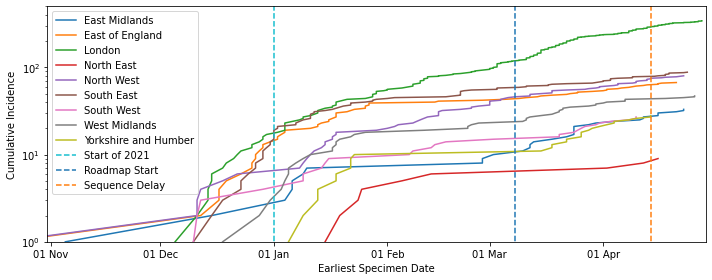

In [16]:
plt.figure(figsize=(10,4))
for i in range(0,len(dfr.index)):
    x = dfr[i]
    plt.plot(np.sort(x),np.arange(1,len(x)+1),label=dfr.index[i])
for i, d in keydates.iterrows():
    plt.plot(todays(d)*np.ones(2),np.array([0,500]),ls='--',label=d.date_name)
plt.legend()
plt.xlabel('Earliest Specimen Date')
plt.ylabel('Cumulative Incidence')
plt.xticks(todays(monthstarts),tods(monthstarts))
plt.xlim([30,210])
plt.ylim([1,500])
plt.yscale('log')
plt.tight_layout()
#plt.savefig('./voc_region_log.pdf')

In [17]:
# From the above, only London seems to exhibit exponential growth so look at that
li = np.argwhere(dfr.index == 'London')[0]
x = dfr[li].values[0]

In [27]:
dfl = df[df.PHEC_name == 'London']
dfl.reset_index(drop=True,inplace=True)
dfl

,finalid,earliest_specimen_date,PHEC_name,specimen_date_sk,seq_result,exposure_type,survey_or_intervention,colindalekits,hh_id
0,-3306285.0,2021-04-28,London,20210428.0,Provisional Genotyping,Awaiting information,NaN,NaN,260.0
1,-3304640.0,2021-04-28,London,20210428.0,Provisional Genotyping,Awaiting information,NaN,NaN,259.0
2,-3303186.0,2021-04-27,London,20210427.0,Provisional Genotyping,Awaiting information,NaN,NaN,257.0
3,-3302065.0,2021-04-27,London,20210427.0,Provisional Genotyping,Awaiting information,NaN,NaN,258.0
4,-3301952.0,2021-04-27,London,20210427.0,Provisional Genotyping,Not travel-associated,NaN,NaN,259.0
...,...,...,...,...,...,...,...,...,...
336,1672456.0,2021-04-16,London,20210416.0,Confirmed,Awaiting information,NaN,NaN,523.0
337,1672489.0,2021-04-08,London,20210408.0,Confirmed,Traveller,NaN,NaN,575.0
338,1672607.0,2021-04-16,London,20210416.0,Confirmed,Awaiting information,NaN,NaN,524.0
339,1672956.0,2021-04-10,London,20210410.0,Confirmed,Not travel-associated,NaN,NaN,525.0


In [18]:
def mymu(x,tt,n):
    mu = np.concatenate([
        x[0]*np.exp(x[1]*tt[0:n]),
        x[0]*np.exp(x[1]*tt[n-1])*np.exp(x[3]*(tt[n:]-tt[n-1]))
    ])
    return mu

def myod(x,tt,n):
    od = np.concatenate([
        x[2]*np.ones(len(tt[0:n])),
        x[4]*np.ones(len(tt[n:]))
    ])
    return od

def mynll(y,x,tt):
    mu = x[0]*np.exp(x[1]*tt)
    od = x[2]*np.ones(len(tt))
    p = 1/od
    r = mu/(od-1)
    return -np.sum(st.nbinom.logpmf(y,r,p))

def mynll2(y,x,tt,n):
    mu = mymu(x,tt,n)
    od = myod(x,tt,n)
    p = 1/od
    r = mu/(od-1)
    return -np.sum(st.nbinom.logpmf(y,r,p))

In [19]:
tk = todays(keydates)
z = np.bincount(x)
yy = z[tk[0]:tk[-1]]
tt = np.arange(0,len(yy))
n = tk[1]-tk[0]

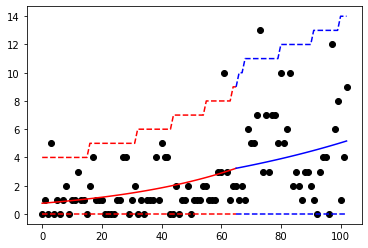

In [20]:
x02 = np.array([1,0.25,5,0.15,5])
nll = lambda xx: mynll2(yy,xx,tt,n)
fout2 = op.minimize(nll,x02,method='Nelder-Mead')   
mu = mymu(fout2.x,tt,n)
od = myod(fout2.x,tt,n)
p = 1/od
r = mu/(od-1)
dt1 = np.log(2.0)/fout2.x[1]
dt2 = np.log(2.0)/fout2.x[3]
plt.plot(tt[0:n],mu[0:n],linestyle='-',c='r',label='Doubling time {:.1f} days'.format(dt1))
plt.plot(tt[(n-1):],mu[(n-1):],linestyle='-',c='b',label='Doubling time {:.1f} days'.format(dt2))
plt.plot(tt[0:n],st.nbinom.ppf(0.025,r[0:n],p[0:n]),linestyle='--',c='r')
plt.plot(tt[0:n],st.nbinom.ppf(0.975,r[0:n],p[0:n]),linestyle='--',c='r')
plt.plot(tt[(n-1):],st.nbinom.ppf(0.025,r[(n-1):],p[(n-1):]),linestyle='--',c='b')
plt.plot(tt[(n-1):],st.nbinom.ppf(0.975,r[(n-1):],p[(n-1):]),linestyle='--',c='b')
plt.scatter(tt,yy,marker='o',c='k',label='Data')

In [21]:
dt1

31.004871242324178

In [22]:
dt2

54.76040817399819

In [ ]:
# TO DO: Add a look 